# 时序预测

本教程介绍了使用 TensorFlow 进行时间序列预测。它构建了几种不同风格的模型，包括卷积和循环神经网络（CNN 和 RNN）

这包括两个主要部分，包括小节：

* 单个时间步长的预测:
  * 单一功能.
  * 所有功能.
* 预测多个步骤:
  * Single-shot: 一次性做出所有预测.
  * 自动回归(Autoregressive): 一次做一个预测并将输出反馈给模型.

## 设置

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## 天气数据集

本教程使用[马克斯普朗克生物地球化学研究所](https://www.bgc-jena.mpg.de)记录的[天气时间序列数据集](https://www.bgc-jena.mpg.de/wetter/)

该数据集包含 14 个不同的特征，例如气温、大气压力和湿度. 从 2003 年开始，每 10 分钟收集一次。为了提高效率，您将仅使用 2009 年至 2016 年间收集的数据。 数据集的这一部分是由 François Chollet 为他的书 [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python) 准备的。

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

本教程将只处理**每小时**的预测，因此首先从 10 分钟间隔到 1 小时间隔对数据进行二次抽样:

In [3]:
df = pd.read_csv(csv_path)
# 切片[开始：停止：步骤]，从索引5开始每 6 取一次
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

让我们看一下数据。这是前几行:

In [4]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


以下是一些功能随时间的演变:

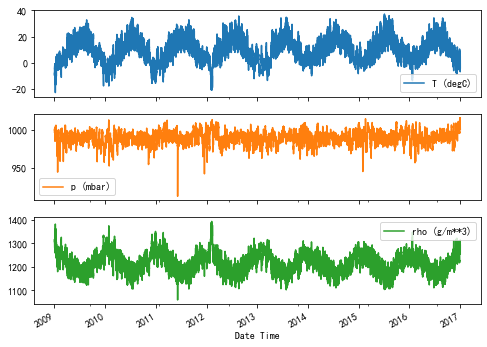

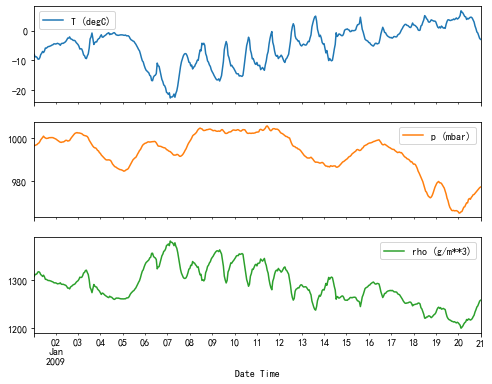

In [5]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

### 检查和清理

接下来看一下数据集的统计数据:

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


#### 风速

应该突出的一件事是风速(`wv (m/s)`)和最大值(`max. wv (m/s)`)列的最小值。这个 -9999 可能是错误的。

有一个单独的风向列，所以速度应该大于零(`>=0`)。用零替换它：

In [7]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# 上述 inplace 编辑反映在 DataFrame 中。
df['wv (m/s)'].min()

0.0

### 特征工程

在深入构建模型之前，了解您的数据并确保您传递的模型具有格式化数据非常重要。

#### 风
数据的最后一列 `wd (deg)`——以度为单位给出风向。角度不是很好的模型输入：360° 和 0° 应该彼此靠近并平滑环绕。如果没有风，方向应该无关紧要。

现在风数据的分布是这样的:

Text(0, 0.5, 'Wind Velocity [m/s]')

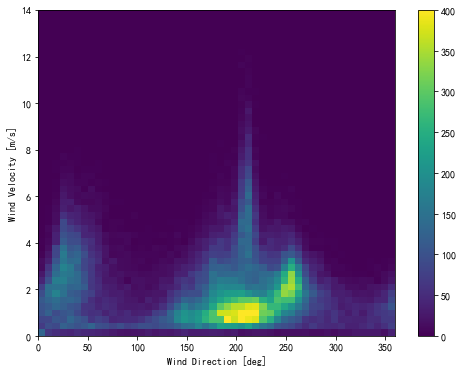

In [8]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

但是，如果将风向和速度列转换为风**矢量**，模型会更容易解释:

In [9]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# 转换为弧度
wd_rad = df.pop('wd (deg)')*np.pi / 180

# 计算风 x 和 y 组件
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# 计算最大风 x 和 y
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

对于正确解释的模型，风矢量的分布要简单得多：

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

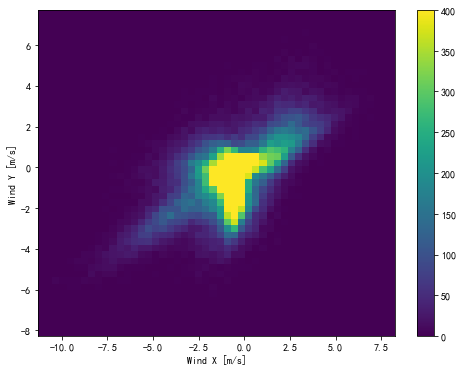

In [10]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

#### 时间

同样，`Date Time` 列非常有用，但不是这种字符串形式。首先将其转换为秒

In [11]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

与风向类似，以秒为单位的时间不是有用的模型输入。作为气象数据，具有明确的日、年周期性。有很多方法可以处理周期性。

您可以通过使用正弦和余弦变换来清除“一天中的时间”和“一年中的时间”信号来获得可用的信号(signals):

In [12]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

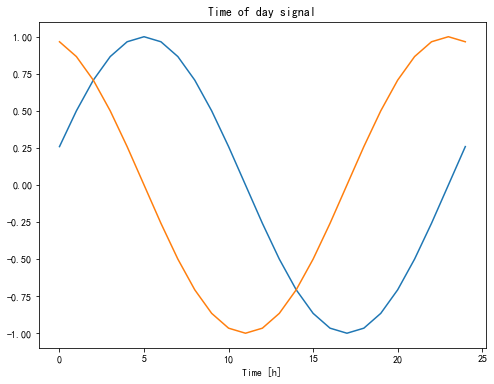

In [13]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

这使模型可以访问最重要的频率特征。在这种情况下，您提前知道哪些频率很重要。

如果您没有该信息，您可以通过使用[快速傅里叶变换](https://en.wikipedia.org/wiki/Fast_Fourier_transform)提取特征来确定哪些频率很重要。为了检查假设，这里是温度随时间变化的 `tf.signal.rfft`。注意频率接近 `1/year` 和 `1/day` 的明显峰值：

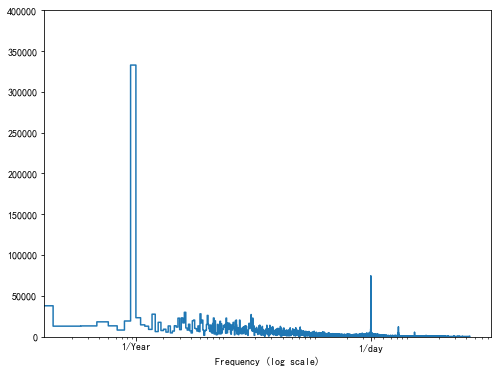

In [14]:
# 显存一下子被吃没了...
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

### 拆分数据

您将对训练、验证和测试集使用`(70%, 20%, 10%)`拆分。请注意，数据在拆分之前将**不会**随机打乱。这有两个原因：

1. 它确保将数据切割成连续样本的窗口中
2. 它确保验证/测试结果更加真实，并根据模型训练后收集的数据进行评估

In [15]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

### 归一化数据

在训练神经网络之前缩放特征很重要。归一化是进行这种缩放的常用方法：减去均值并除以每个特征的标准差。

均值和标准差只能使用训练数据来计算，这样模型就无法访问验证集和测试集中的值。

它还可以说明该模型在训练时，不应该访问训练集的未来值，并且应使用移动平均线进行这种归一化。这不是本教程的重点，验证和测试集可确保您获得（有些）诚实的指标。因此，为了简单起见，本教程使用简单的平均值。

In [16]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

现在，看看特征的分布。有些特征确实有长尾，但没有像 `-9999` 风速值这样的明显误差。

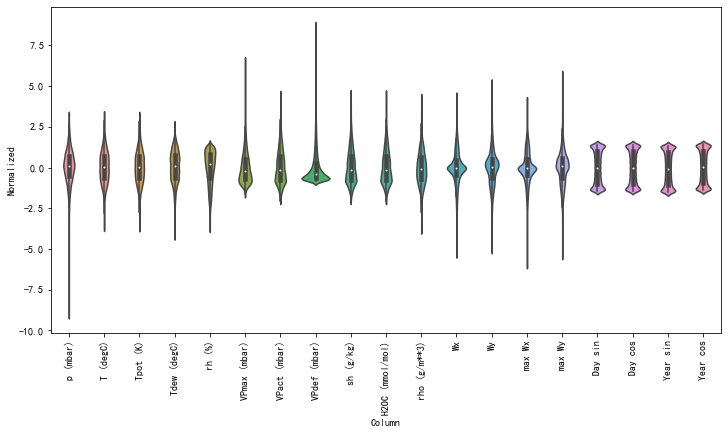

In [17]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## 数据窗口

本教程中的模型将根据数据中的连续样本窗口进行一组预测。

输入窗口的主要特点是:

- 输入和标签窗口的宽度（时间步数）
- 它们之间的时间偏移
- 哪些特征用作输入、标签或两者兼有

本教程构建了多种模型（包括线性、DNN、CNN 和 RNN 模型），并将它们用于两者:

- 单输出(*Single-output*)和多输出(*multi-output*)预测
- 单时间步(*Single-time-step*)和多时间步(*multi-time-step*)预测

本节重点介绍数据窗口的实现，以便可以将其重用于所有这些模型

根据任务和模型类型，您可能希望生成各种数据窗口。这里有些例子:

1. 要对未来 24 小时进行一次预测，给定 24 小时的历史，您可以定义一个像这样的窗口:

  ![One prediction 24 hours into the future.](https://tensorflow.google.cn/tutorials/structured_data/images/raw_window_24h.png)

2. 给定六个小时的历史，一次预测未来一小时的模型需要这样的窗口:

  ![One prediction one hour into the future.](https://tensorflow.google.cn/tutorials/structured_data/images/raw_window_1h.png)

本节的其余部分定义了一个 `WindowGenerator` 类。这个类可以:

1. 如上图所示处理索引和偏移量
2. 将特征窗口拆分为 `(features, labels)` 对
3. 绘制结果窗口的内容
4. 使用 `tf.data.Dataset` 从训练、评估和测试数据中高效地生成这些窗口的批次

### 1. 索引和偏移量

首先创建 `WindowGenerator` 类。 `__init__` 方法包括输入和标签索引的所有必要逻辑。

它还将训练、评估和测试数据帧作为输入。这些将在稍后转换为 windows 的 `tf.data.Dataset`。

In [18]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # 获取标签列指数(indices)
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # 设置窗口参数。
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

以下是创建本节开头图表中显示的 2 个窗口的代码:

In [19]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [20]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

### 2. 拆分

给定一个连续输入的列表，`split_window` 方法会将它们转换为一个输入窗口和一个标签窗口

您之前定义的示例 `w2` 将像这样拆分：

![The initial window is all consecutive samples, this splits it into an (inputs, labels) pairs](https://tensorflow.google.cn/tutorials/structured_data/images/split_window.png)

此图未显示数据的特征(`features`)轴，但此 `split_window` 函数还处理 `label_columns`，因此它可用于单输出和多输出示例。

In [21]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # 切片不保留静态形状信息，因此请手动设置形状
  # 这样 `tf.data.Datasets` 更容易检查
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

试试看:

In [22]:
# 堆叠三个切片，总窗口的长度
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('所有形状格式为: (批量(batch), 时间长度(time), 特征(features))')
print(f'窗口形状: {example_window.shape}')
print(f'输入形状: {example_inputs.shape}')
print(f'标签形状: {example_labels.shape}')

所有形状格式为: (批量(batch), 时间长度(time), 特征(features))
窗口形状: (3, 7, 19)
输入形状: (3, 6, 19)
标签形状: (3, 1, 1)


通常，TensorFlow 中的数据被打包到数组中，其中最外层索引为批量数（“批(batch)”维度）。中间索引是“时间”或“空间”（宽度、高度）维度。最里面的索引是特征。

上面的代码在每个时间步采用了一批三个 7 次(7-time)步长的窗口，其中包含 19 个特征。它将它们分成一批 6 步 19 特征输入和一个 1 步 1 特征标签。
上面的代码使用了 3 批时间步长为 7 的窗口，每个时间步长有 19 个特征。split_window 方法将它们拆分为每批 6 个时间步长、19 个特征输入和每批 1 个时间步长、1个标签。该标签只有一项特征，这是因为 `WindowGenerator` 仅使用 `label_columns=['T (degC)']` 进行初始化。目前，我们先构建预测单输出的模型。

### 3. 绘图(Plot)

让我们将拆分后的窗口可视化，图中的数据根据其引用的时间来对齐输入、标签和预测：

In [23]:
w2.example = example_inputs, example_labels

In [24]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

此图根据项目引用的时间对齐输入、标签和（稍后）预测:

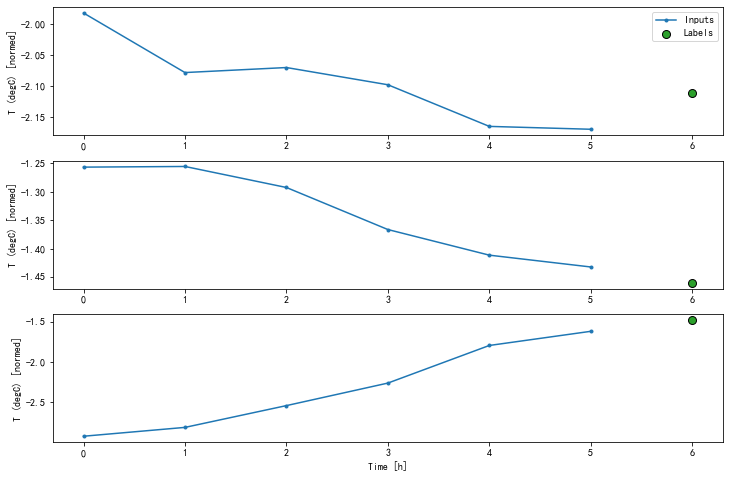

In [25]:
w2.plot()

你可以通过更改函数的参数来绘制其他特征列，但示例 `w2` 中仅存在 `T (degC)` 的标签。

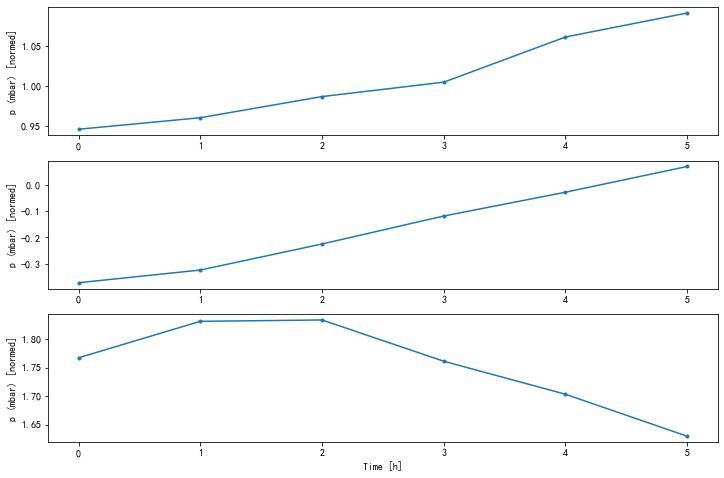

In [26]:
w2.plot(plot_col='p (mbar)')

### 4. 创建 `tf.data.Dataset`

最后，此 `make_dataset` 方法会使用 `tf.keras.utils.timeseries_dataset_from_array` 函数将采用时间序列的 DataFrame 转换为形如 `(input_window, label_window)` 对的 `tf.data.Dataset`:

In [27]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

`WindowGenerator` 对象保存训练、验证和测试数据

使用上述的 `make_dataset` 方法可用于添加 `tf.data.Dataset` 属性，还可以添加一个标准批处理示例，便于访问和打印：

In [28]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """获取并缓存一批用于绘图的示例`inputs, labels`"""
  result = getattr(self, '_example', None)
  if result is None:
    # 没有找到示例批次，所以从 `.train` 数据集中获取一个
    result = next(iter(self.train))
    # 并将其缓存以备下次使用
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

现在，`WindowGenerator` 对象使你能够访问 `tf.data.Dataset` 对象并轻松地遍历所有数据

`Dataset.element_spec` 属性可以告诉你数据集元素的结构、数据类型和形状。

In [29]:
# 每个元素都是一个 (inputs, label) 数据对
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

遍历数据集(`Dataset`)会生成批量的数据对:

In [30]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'输入形状 (批量(batch), 时间步长(time), 特征(features)): {example_inputs.shape}')
  print(f'标签形状 (批量(batch), 时间步长(time), 特征(features)): {example_labels.shape}')

输入形状 (批量(batch), 时间步长(time), 特征(features)): (32, 6, 19)
标签形状 (批量(batch), 时间步长(time), 特征(features)): (32, 1, 1)


## 单步模型

您可以在此类数据上构建的最简单模型是仅根据当前条件预测单个特征值的模型——即仅预测未来的 1 个时间步（一小时）

因此，首先构建模型来预测未来一小时的 `T (degC)`  值

![Predict the next time step](https://tensorflow.google.cn/tutorials/structured_data/images/narrow_window.png)

配置一个 `WindowGenerator` 对象以生成单步的 `(input, label)` 数据对

In [31]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

`window` 对象从训练集、验证集和测试集创建 `tf.data.Dataset`，让您可以轻松地迭代成批数据

In [32]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'输入形状 (批量数, 时间步长, 特征): {example_inputs.shape}')
  print(f'标签形状 (批量数, 时间步长, 特征): {example_labels.shape}')

输入形状 (批量数, 时间步长, 特征): (32, 1, 19)
标签形状 (批量数, 时间步长, 特征): (32, 1, 1)


### 基准模型(Baseline)

Before building a trainable model it would be good to have a performance baseline as a point for comparison with the later more complicated models.

This first task is to predict temperature one hour into the future, given the current value of all features. The current values include the current temperature. 

So, start with a model that just returns the current temperature as the prediction, predicting "No change". This is a reasonable baseline since temperature changes slowly. Of course, this baseline will work less well if you make a prediction further in the future.
在构建可训练的模型之前，最好先设立性能基准以与之后更复杂的模型进行比较

这里的首要任务为基于当前所有的特征值对未来一小时的温度进行预测，这里的特征值可包含当前的温度

因此，从一个仅返回当前温度作为预测的模型开始，预测“没有变化”。这是一个合理的基线，因为温度变化缓慢。当然，如果要做进一步的预测，这个基准模型将难以发挥作用。

![Send the input to the output](https://tensorflow.google.cn/tutorials/structured_data/images/baseline.png)

In [33]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

实例化并评估这个模型:

In [34]:
baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

439/439 [==============================] - 1s 2ms/step - loss: 0.0128 - mean_absolute_error: 0.0785


这打印了一些性能指标，但这些指标并不能让您感觉模型的表现如何

`WindowGenerator` 有一个 plot 方法，但只绘制一个样本并没有太大意思

因此，让我们创建一个更大的 `WindowGenerator`，一次生成窗口宽度为 24 小时的连续输入和标签。新的 `wide_window` 并不会改变模型的运行方式，其仍然基于单个输入时间步长对未来一小时进行预测。在这里，时间(`time`)轴的作用类似于批量(`batch`)轴：每个预测都是独立进行的，每个时间步之间没有交互:

In [35]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

这个扩展窗口可以直接传递给相同的基准(`baseline`)模型，而无需更改任何代码。这是因为输入和标签具有相同的时间步长，基准仅将输入转发到输出：

![One prediction 1h into the future, ever hour.](https://tensorflow.google.cn/tutorials/structured_data/images/last_window.png)

In [36]:
print('输入形状:', wide_window.example[0].shape)
print('输出形状:', baseline(wide_window.example[0]).shape)

输入形状: (32, 24, 19)
输出形状: (32, 24, 1)


通过绘制基线模型的预测，请注意它只是标签右移一小时：

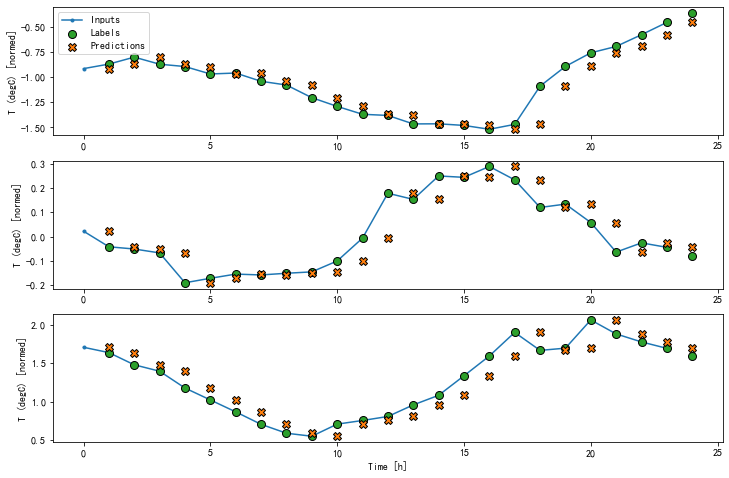

In [37]:
wide_window.plot(baseline)

在上面三个示例图中，单步模型运行了 24 小时。我们需要做一些解释:

- 蓝色输入线显示每个时间步的输入温度。模型接收所有特征，此图仅显示温度
- 绿色标签点显示目标预测值。这些点显示在预测时间，而不是输入时间。这就是标签范围相对于输入移动 1 步的原因
- The orange `Predictions` crosses are the model's prediction's for each output time step. If the model were predicting perfectly the predictions would land directly on the `Labels`.
- 橙色的预测(`Predictions`)交叉点是模型对每个输出时间步长的预测。如果模型预测完美，则预测将直接落在标签上

### 线性模型(Linear model)

您可以应用于此任务的最简单的**可训练**模型是在输入和输出之间插入线性变换。在这种情况下，时间步的输出仅取决于该步:

![A single step prediction](https://tensorflow.google.cn/tutorials/structured_data/images/narrow_window.png)

没有激活(`activation`)集的 `tf.keras.layers.Dense` 层是线性模型。该线性层仅将数据的最后一个轴从 `(batch, time, inputs)` 转换为 `(batch, time, units)`；它独立应用于批次和时间轴上的每一项

In [38]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [39]:
print('输入形状:', single_step_window.example[0].shape)
print('输出形状:', linear(single_step_window.example[0]).shape)

输入形状: (32, 1, 19)
输出形状: (32, 1, 1)


本教程训练了很多模型，所以将训练过程打包成一个函数:

In [40]:
MAX_EPOCHS = 10

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

训练模型并评估其性能:

In [41]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/10
1534/1534 [==============================] - 6s 3ms/step - loss: 0.0586 - mean_absolute_error: 0.1614 - val_loss: 0.0149 - val_mean_absolute_error: 0.0906
Epoch 2/10
1534/1534 [==============================] - 5s 3ms/step - loss: 0.0120 - mean_absolute_error: 0.0818 - val_loss: 0.0100 - val_mean_absolute_error: 0.0738
Epoch 3/10
1534/1534 [==============================] - 5s 4ms/step - loss: 0.0098 - mean_absolute_error: 0.0728 - val_loss: 0.0091 - val_mean_absolute_error: 0.0705
Epoch 4/10
1534/1534 [==============================] - 5s 3ms/step - loss: 0.0094 - mean_absolute_error: 0.0713 - val_loss: 0.0090 - val_mean_absolute_error: 0.0699
Epoch 5/10
1534/1534 [==============================] - 6s 4ms/step - loss: 0.0093 - mean_absolute_error: 0.0708 - val_loss: 0.0090 - val_mean_absolute_error: 0.0699
Epoch 6/10
1534/1534 [==============================] - 5s 3ms/step - loss: 0.0092 - mean_absolute_error: 0.0706 - val_loss: 0.0089 - val_mean_absolute_error: 0.0695
Epoc

与基线(`baseline`)模型一样，线性模型可以在批量的宽窗口上调用线性模型。使用这种方式，模型会对连续的时间步长进行一组独立的预测。`time` 轴就像另一个 `batch` 轴。每个时间步的预测之间没有相互作用。

![A single step prediction](https://tensorflow.google.cn/tutorials/structured_data/images/wide_window.png)

In [42]:
print('输入形状:', wide_window.example[0].shape)
print('输出形状:', baseline(wide_window.example[0]).shape)

输入形状: (32, 24, 19)
输出形状: (32, 24, 1)


下图是线性模型在 `wide_window` 上的预测示例图，请注意在大多数情况下预测明显优于仅返回输入温度，但在少数情况下情况更糟:

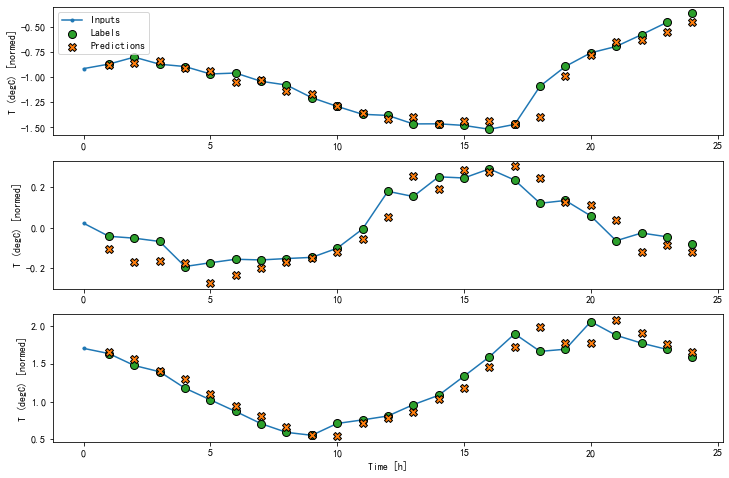

In [43]:
wide_window.plot(linear)

线性模型的一个优点是它们相对容易解释。您可以抽取线性层的权重并可视化分配给每个输入的权重：

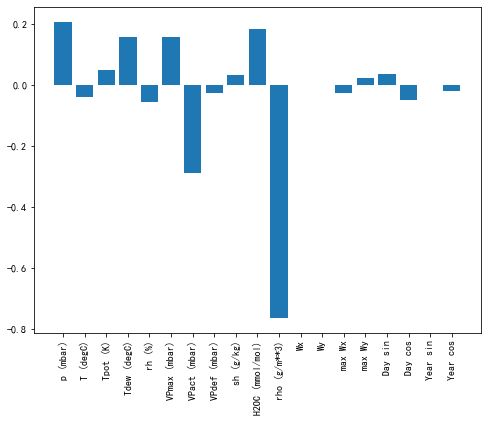

In [44]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

从上图可以看出，有时模型甚至没有将最大权重放在输入 `T (degC)` 上。这是随机初始化权重的风险之一

### 稠密连接(Dense)

在应用可在多个时间步上运行的模型之前，有必要检查更深入、更强大的单输入步模型的性能。

下面是一个类似于线性模型的模型，不同之处在于它在输入和输出之间堆叠了若干个 `Dense` 层:

In [45]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/10
1534/1534 [==============================] - 8s 5ms/step - loss: 0.0149 - mean_absolute_error: 0.0784 - val_loss: 0.0082 - val_mean_absolute_error: 0.0664
Epoch 2/10
1534/1534 [==============================] - 8s 5ms/step - loss: 0.0078 - mean_absolute_error: 0.0642 - val_loss: 0.0074 - val_mean_absolute_error: 0.0630
Epoch 3/10
1534/1534 [==============================] - 7s 5ms/step - loss: 0.0075 - mean_absolute_error: 0.0625 - val_loss: 0.0071 - val_mean_absolute_error: 0.0606
Epoch 4/10
1534/1534 [==============================] - 7s 5ms/step - loss: 0.0072 - mean_absolute_error: 0.0609 - val_loss: 0.0069 - val_mean_absolute_error: 0.0591
Epoch 5/10
1534/1534 [==============================] - 8s 5ms/step - loss: 0.0071 - mean_absolute_error: 0.0603 - val_loss: 0.0068 - val_mean_absolute_error: 0.0582
Epoch 6/10
1534/1534 [==============================] - 7s 5ms/step - loss: 0.0069 - mean_absolute_error: 0.0593 - val_loss: 0.0068 - val_mean_absolute_error: 0.0593
Epoc

### 多步稠密连接(Multi-step dense)

单时间步模型没有关于其当前输入值的上下文。因而其看不到输入特征随时间变化的情况。为了解决这个问题，模型在进行预测时需要访问多个时间步:

![Three time steps are used for each prediction.](https://tensorflow.google.cn/tutorials/structured_data/images/conv_window.png)

基线(`baseline`)、线性(`linear`)和密集(`dense`)模型独立处理每个时间步。而此模型将采用多个时间步长作为输入并产生单个输出

创建一个 `WindowGenerator`，它将生成一批 3 小时输入和 1 小时标签:

请注意，`Window` 的 `shift` 参数是相对于两个窗口的末尾的

In [46]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

Text(0.5, 1.0, '给定 3 小时的输入，预测未来 1 小时')

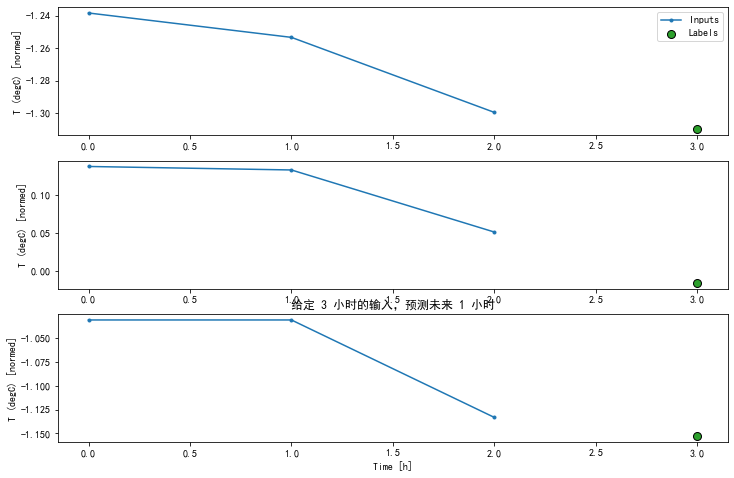

In [47]:
# 中文报错参考 http://zsduo.com/archives/262.html，不能删除 '#'
# 查找字体路径
# print(mpl.matplotlib_fname())
# 查找字体缓存路径
# print(mpl.get_cachedir())

conv_window.plot()
# 给定 3 小时的输入，预测未来 1 小时
plt.title("给定 3 小时的输入，预测未来 1 小时")

您可以通过添加 `tf.keras.layers.Flatten` 作为模型的第一层，训练多输入窗口的 `dense` 模型

In [48]:
multi_step_dense = tf.keras.Sequential([
    # 形状: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # 重新添加时间轴
    # 形状: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [49]:
print('输入形状:', conv_window.example[0].shape)
print('输出形状:', multi_step_dense(conv_window.example[0]).shape)

输入形状: (32, 3, 19)
输出形状: (32, 1, 1)


In [50]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

438/438 [==============================] - 1s 2ms/step - loss: 0.0076 - mean_absolute_error: 0.0642


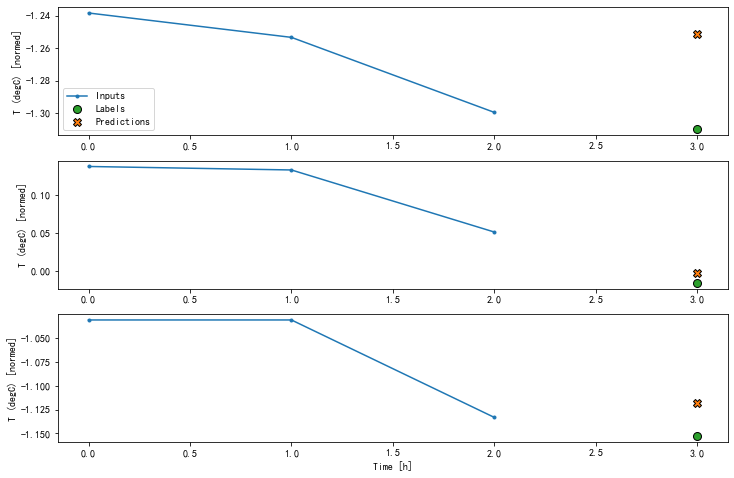

In [51]:
conv_window.plot(multi_step_dense)

这种方法的主要缺点是生成的模型只能在具有这种形状的输入窗口上执行

In [52]:
print('输入形状:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

输入形状: (32, 24, 19)

ValueError:Exception encountered when calling layer "sequential_2" (type Sequential).

Input 0 of layer "dense_4" is incompatible with the layer: expected axis -1 of input shape to have value 57, but received input with shape (32, 456)

Call arguments received:
  • inputs=tf.Tensor(shape=(32, 24, 19), dtype=float32)
  • training=None
  • mask=None


下一节中的卷积模型解决了这个问题

### 卷积神经网络(Convolution neural network)
 
卷积层(`tf.keras.layers.Conv1D`)同样可以将多个时间步作为每个预测的输入

下面是与 `multi_step_dense` **相同**的模型，用卷积重写

不同之处在于:

* `tf.keras.layers.Flatten` 和第一个 `tf.keras.layers.Dense` 被 `tf.keras.layers.Conv1D` 替换
* 由于卷积运算可在输出中保留时间轴，无需再使用 `tf.keras.layers.Reshape`

In [53]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

在示例批次上运行它以检查模型输出的形状是否符合我们的预期:

In [54]:
print("`conv_window`上的卷积模型")
print('输入形状:', conv_window.example[0].shape)
print('输出形状:', conv_model(conv_window.example[0]).shape)

`conv_window`上的卷积模型
输入形状: (32, 3, 19)
输出形状: (32, 1, 1)


在 `conv_window` 上训练和评估它，它应该提供类似于 `multi_step_dense` 模型的性能

> 如果内核挂掉，报 `Could not locate zlibwapi.dll. Please make sure it is in your library path!` 错误
>
> 参考 [3.1.3. Installing zlib](https://docs.nvidia.com/deeplearning/cudnn/install-guide/index.html#install-zlib-windows) 安装扩展程序

In [55]:
history = compile_and_fit(conv_model, conv_window)
IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

438/438 [==============================] - 1s 3ms/step - loss: 0.0060 - mean_absolute_error: 0.0539


这个 `conv_model` 和 `multi_step_dense` 模型之间的区别在于 `conv_model` 可以在任何长度的输入上运行。卷积层可以应用于一个滑动的输入窗口：

![Executing a convolutional model on a sequence](https://tensorflow.google.cn/tutorials/structured_data/images/wide_conv_window.png)

如果你提供更宽的输入，那么模型也会产生更宽的输出：

In [56]:
print("宽窗口")
print('输入形状:', wide_window.example[0].shape)
print('标签形状:', wide_window.example[1].shape)
print('输出形状:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


需要注意的是，输出比输入要窄，如果要进行训练或绘图，需要标签和预测具有相同的长度。因此，构建一个 `WindowGenerator` 来生成带有一些额外输入时间步长的宽窗口，以便标签和预测长度匹配：

In [57]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']

In [58]:
print("Wide conv window")
print('输入形状:' wide_conv_window.example[0].shape)
print('标签形状:', wide_conv_window.example[1].shape)
print('输出形状:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


现在，您可以在更宽的窗口上绘制模型的预测。请注意第一次预测之前的 3 个输入时间步长。这里的每个预测都是基于前面的 3 个时间步长：

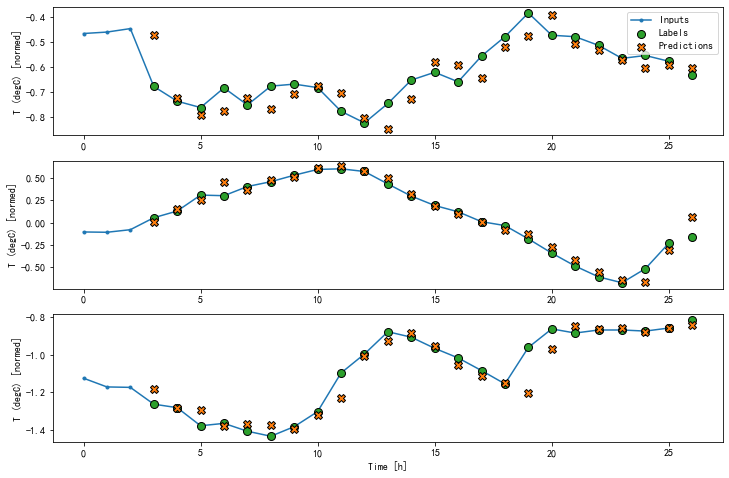

In [59]:
wide_conv_window.plot(conv_model)

### 循环神经网络(Recurrent neural network)

循环神经网络(RNN)是一种非常适合时间序列数据的神经网络。它分步处理时间序列，从一个时间步切换到下一时间步均保持内部状态

您可以在使用 [RNN 的文本生成](https://www.tensorflow.org/text/tutorials/text_generation)教程和[使用 Keras 的递归神经网络 (RNN)](https://www.tensorflow.org/guide/keras/rnn)指南中了解更多信息

在本教程中，我们将使用名为 Long Short-Term Memory (`tf.keras.layers.LSTM`) 的 RNN 层

所有 Keras RNN 层（例如 `tf.keras.layers.LSTM`）的一个重要构造函数参数是 `return_sequences` 参数。此设置可以通过以下两种方式之一配置 RNN 层：

1. If `False`, the default, the layer only returns the output of the final time step, giving the model time to warm up its internal state before making a single prediction: 
1. 如果默认为 `False`，则该层仅返回最后一个时间步的输出，让模型有时间在进行单个预测之前预热其内部状态：

![An LSTM warming up and making a single prediction](https://tensorflow.google.cn/tutorials/structured_data/images/lstm_1_window.png)

2. 如果为 True，则该层为每个输入返回一个输出。有利于：
  * 堆叠 RNN 层 
  * 同时在多个时间步上训练模型.

![An LSTM making a prediction after every time step](https://tensorflow.google.cn/tutorials/structured_data/images/lstm_many_window.png)

In [60]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

通过设置 `return_sequences=True`，模型可以一次训练 24 小时的数据

注意：这将对模型的性能产生悲观效果。在第一个时间步，该模型无法访问之前的步骤，因此无法比前面显示的简单 `linear` 和 `dense` 模型做得更好

In [61]:
print('输入形状:', wide_window.example[0].shape)
print('输出形状:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


In [62]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

438/438 [==============================] - 1s 3ms/step - loss: 0.0057 - mean_absolute_error: 0.0523


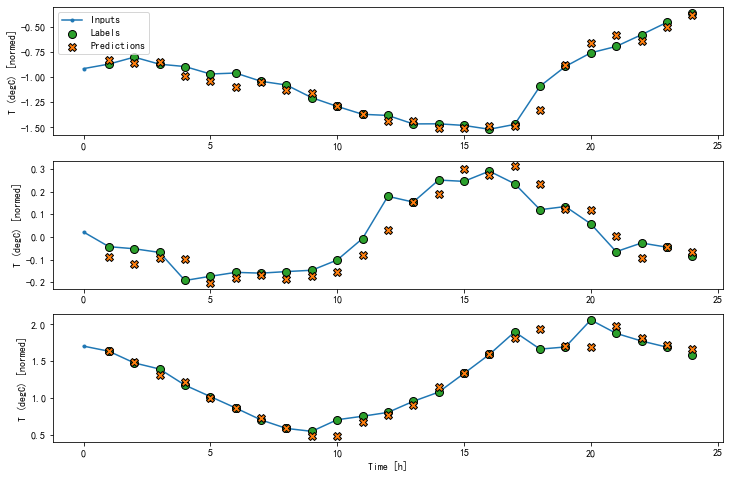

In [63]:
wide_window.plot(lstm_model)

### 输出形状(Performance)

使用这个数据集，每个模型的性能都比之前的模型好一些

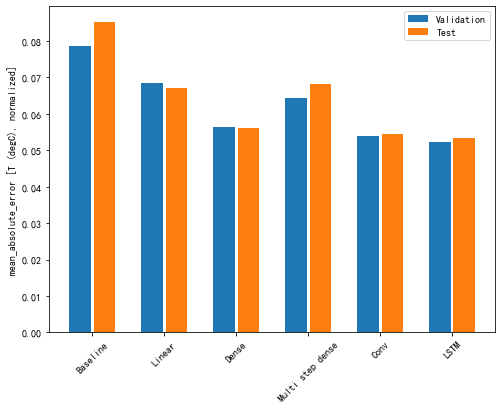

In [64]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('平均绝对误差 [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [65]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0852
Linear      : 0.0670
Dense       : 0.0560
Multi step dense: 0.0682
Conv        : 0.0544
LSTM        : 0.0532


### 平均绝对误差(Multi-output models)

The models so far all predicted a single output feature, `T (degC)`, for a single time step.

All of these models can be converted to predict multiple features just by changing the number of units in the output layer and adjusting the training windows to include all features in the `labels` (`example_labels`):

### 平均绝对误差(Multi-output models)

到目前为止，这些模型都预测了单个时间步长的单个输出特征 `T (degC)`

只需更改输出层中的单元数并调整训练窗口以包含标签(`example_labels`)中的所有特征，便可将这些模型转换为多输出模型:

In [66]:
single_step_window = WindowGenerator(
    # 如果不设置 `label_columns` 参数，`WindowGenerator` 会将所有特征作为标签返回
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'输入形状 (批量数, 时间步, 特征数): {example_inputs.shape}')
  print(f'标签形状 (批量数, 时间步, 特征数): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 19)
Labels shape (batch, time, features): (32, 24, 19)


Note above that the `features` axis of the labels now has the same depth as the inputs, instead of `1`.

#### Baseline

The same baseline model (`Baseline`) can be used here, but this time repeating all features instead of selecting a specific `label_index`:

In [67]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [68]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

438/438 [==============================] - 1s 2ms/step - loss: 0.0886 - mean_absolute_error: 0.1589


#### Dense

In [69]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [70]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

439/439 [==============================] - 2s 3ms/step - loss: 0.0686 - mean_absolute_error: 0.1338


#### RNN


In [71]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

438/438 [==============================] - 1s 3ms/step - loss: 0.0619 - mean_absolute_error: 0.1213

Wall time: 1min 26s


<a id="residual"></a>

#### Advanced: Residual connections

The `Baseline` model from earlier took advantage of the fact that the sequence doesn't change drastically from time step to time step. Every model trained in this tutorial so far was randomly initialized, and then had to learn that the output is a a small change from the previous time step.

While you can get around this issue with careful initialization, it's  simpler to build this into the model structure.

It's common in time series analysis to build models that instead of predicting the next value, predict how the value will change in the next time step. Similarly, <a href="https://arxiv.org/abs/1512.03385" class="external">residual networks</a>—or ResNets—in deep learning refer to architectures where each layer adds to the model's accumulating result.

That is how you take advantage of the knowledge that the change should be small.

![A model with a residual connection](https://tensorflow.google.cn/tutorials/structured_data/images/residual.png)

Essentially, this initializes the model to match the `Baseline`. For this task it helps models converge faster, with slightly better performance.

This approach can be used in conjunction with any model discussed in this tutorial. 

Here, it is being applied to the LSTM model, note the use of the `tf.initializers.zeros` to ensure that the initial predicted changes are small, and don't overpower the residual connection. There are no symmetry-breaking concerns for the gradients here, since the `zeros` are only used on the last layer.

In [72]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [73]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

438/438 [==============================] - 1s 3ms/step - loss: 0.0616 - mean_absolute_error: 0.1173

Wall time: 55.6 s


#### Performance

Here is the overall performance for these multi-output models.

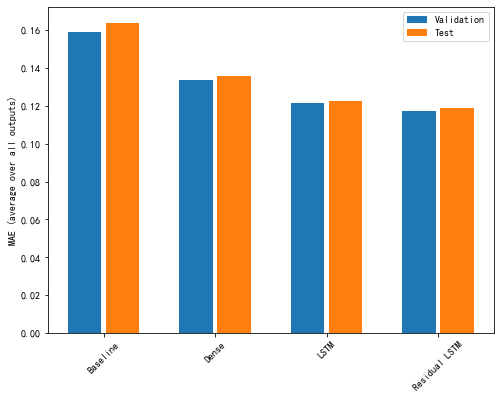

In [74]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [75]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.1638
Dense          : 0.1357
LSTM           : 0.1227
Residual LSTM  : 0.1189


The above performances are averaged across all model outputs.

## Multi-step models

Both the single-output and multiple-output models in the previous sections made **single time step predictions**, one hour into the future.

This section looks at how to expand these models to make **multiple time step predictions**.

In a multi-step prediction, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predicts a sequence of the future values.

There are two rough approaches to this:

1. Single shot predictions where the entire time series is predicted at once.
2. Autoregressive predictions where the model only makes single step predictions and its output is fed back as its input.

In this section all the models will predict **all the features across all output time steps**.


For the multi-step model, the training data again consists of hourly samples. However, here, the models will learn to predict 24 hours into the future, given 24 hours of the past.

Here is a `Window` object that generates these slices from the dataset:

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

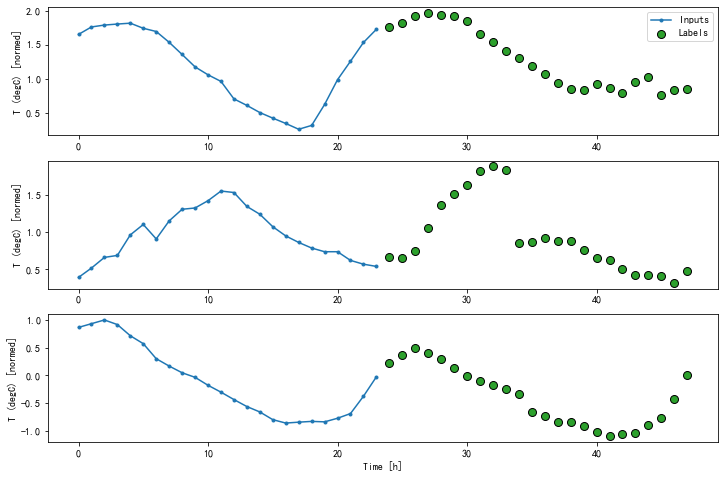

In [76]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

### Baselines

A simple baseline for this task is to repeat the last input time step for the required number of output time steps:

![Repeat the last input, for each output step](https://tensorflow.google.cn/tutorials/structured_data/images/multistep_last.png)

437/437 [==============================] - 1s 2ms/step - loss: 0.6285 - mean_absolute_error: 0.5007


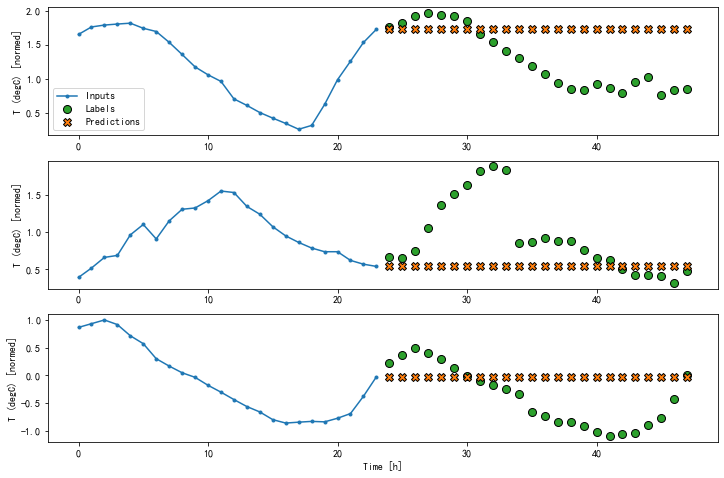

In [77]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

Since this task is to predict 24 hours into the future, given 24 hours of the past, another simple approach is to repeat the previous day, assuming tomorrow will be similar:

![Repeat the previous day](https://tensorflow.google.cn/tutorials/structured_data/images/multistep_repeat.png)

437/437 [==============================] - 1s 2ms/step - loss: 0.4270 - mean_absolute_error: 0.3959


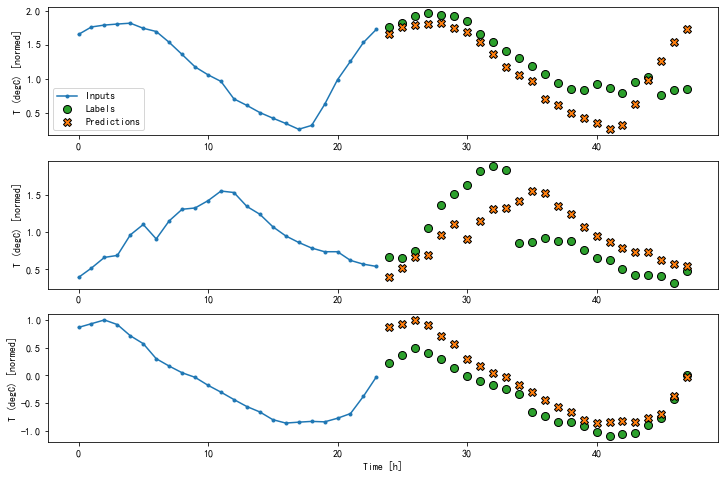

In [78]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

### Single-shot models

One high-level approach to this problem is to use a "single-shot" model, where the model makes the entire sequence prediction in a single step.

This can be implemented efficiently as a `tf.keras.layers.Dense` with `OUT_STEPS*features` output units. The model just needs to reshape that output to the required `(OUTPUT_STEPS, features)`.

#### Linear

A simple linear model based on the last input time step does better than either baseline, but is underpowered. The model needs to predict `OUTPUT_STEPS` time steps, from a single input time step with a linear projection. It can only capture a low-dimensional slice of the behavior, likely based mainly on the time of day and time of year.

![Predict all timesteps from the last time-step](https://tensorflow.google.cn/tutorials/structured_data/images/multistep_dense.png)

437/437 [==============================] - 1s 2ms/step - loss: 0.2552 - mean_absolute_error: 0.3047


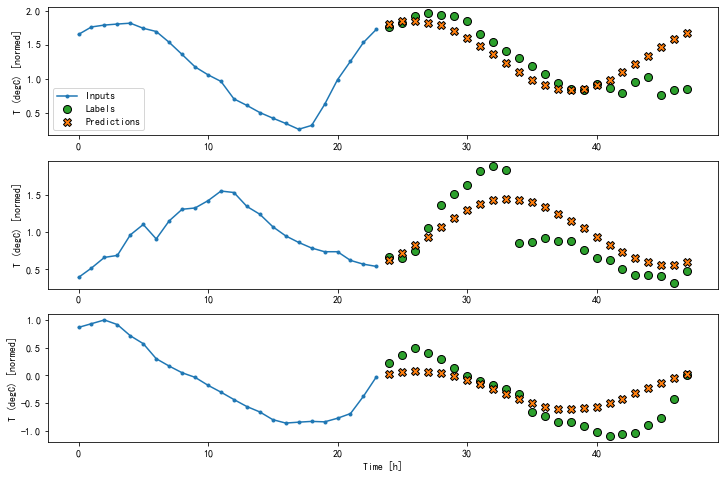

In [79]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

#### Dense

Adding a `tf.keras.layers.Dense` between the input and output gives the linear model more power, but is still only based on a single input time step.

437/437 [==============================] - 1s 3ms/step - loss: 0.2199 - mean_absolute_error: 0.2825


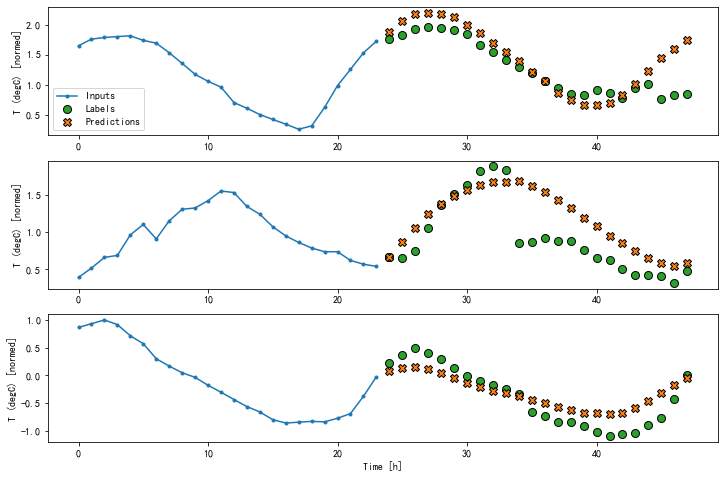

In [80]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

#### CNN

A convolutional model makes predictions based on a fixed-width history, which may lead to better performance than the dense model since it can see how things are changing over time:

![A convolutional model sees how things change over time](https://tensorflow.google.cn/tutorials/structured_data/images/multistep_conv.png)

437/437 [==============================] - 1s 3ms/step - loss: 0.2137 - mean_absolute_error: 0.2803


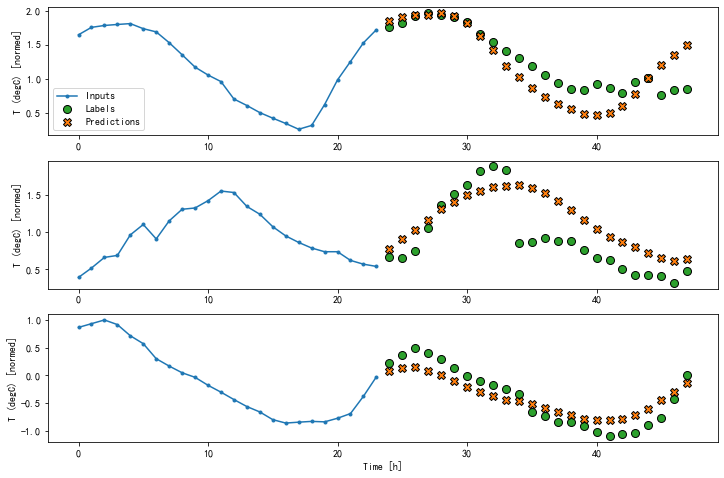

In [81]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

#### RNN

A recurrent model can learn to use a long history of inputs, if it's relevant to the predictions the model is making. Here the model will accumulate internal state for 24 hours, before making a single prediction for the next 24 hours.

In this single-shot format, the LSTM only needs to produce an output at the last time step, so set `return_sequences=False` in `tf.keras.layers.LSTM`.

![The LSTM accumulates state over the input window, and makes a single prediction for the next 24 hours](https://tensorflow.google.cn/tutorials/structured_data/images/multistep_lstm.png)


437/437 [==============================] - 1s 3ms/step - loss: 0.2120 - mean_absolute_error: 0.2821


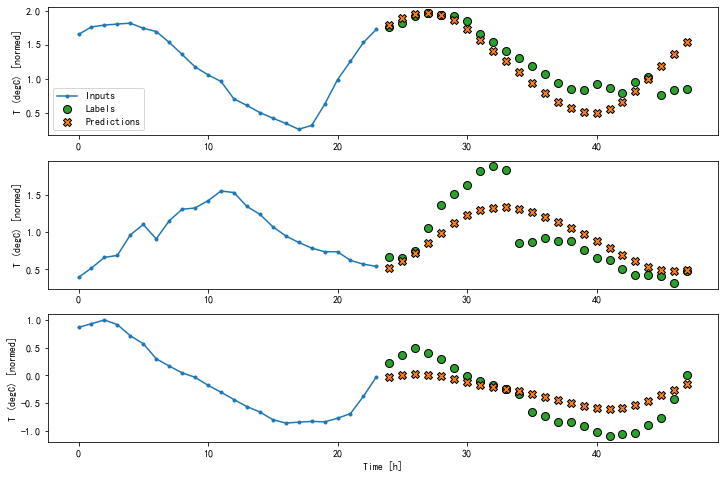

In [82]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

### Advanced: Autoregressive model

The above models all predict the entire output sequence in a single step.

In some cases it may be helpful for the model to decompose this prediction into individual time steps. Then, each model's output can be fed back into itself at each step and predictions can be made conditioned on the previous one, like in the classic <a href="https://arxiv.org/abs/1308.0850" class="external">Generating Sequences With Recurrent Neural Networks</a>.

One clear advantage to this style of model is that it can be set up to produce output with a varying length.

You could take any of the single-step multi-output models trained in the first half of this tutorial and run in an autoregressive feedback loop, but here you'll focus on building a model that's been explicitly trained to do that.

![Feedback a model's output to its input](https://tensorflow.google.cn/tutorials/structured_data/images/multistep_autoregressive.png)

#### RNN

This tutorial only builds an autoregressive RNN model, but this pattern could be applied to any model that was designed to output a single time step.

The model will have the same basic form as the single-step LSTM models from earlier: a `tf.keras.layers.LSTM` layer followed by a `tf.keras.layers.Dense` layer that converts the `LSTM` layer's outputs to model predictions.

A `tf.keras.layers.LSTM` is a `tf.keras.layers.LSTMCell` wrapped in the higher level `tf.keras.layers.RNN` that manages the state and sequence results for you (Check out the [Recurrent Neural Networks (RNN) with Keras](https://www.tensorflow.org/guide/keras/rnn) guide for details).

In this case, the model has to manually manage the inputs for each step, so it uses `tf.keras.layers.LSTMCell` directly for the lower level, single time step interface.

In [83]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [84]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

The first method this model needs is a `warmup` method to initialize its internal state based on the inputs. Once trained, this state will capture the relevant parts of the input history. This is equivalent to the single-step `LSTM` model from earlier:

In [85]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

This method returns a single time-step prediction and the internal state of the `LSTM`:

In [86]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 19])

With the `RNN`'s state, and an initial prediction you can now continue iterating the model feeding the predictions at each step back as the input.

The simplest approach for collecting the output predictions is to use a Python list and a `tf.stack` after the loop.

Note: Stacking a Python list like this only works with eager-execution, using `Model.compile(..., run_eagerly=True)` for training, or with a fixed length output. For a dynamic output length, you would need to use a `tf.TensorArray` instead of a Python list, and `tf.range` instead of the Python `range`.

In [87]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

Test run this model on the example inputs:

In [88]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 19)


Now, train the model:

437/437 [==============================] - 9s 21ms/step - loss: 0.2248 - mean_absolute_error: 0.2993


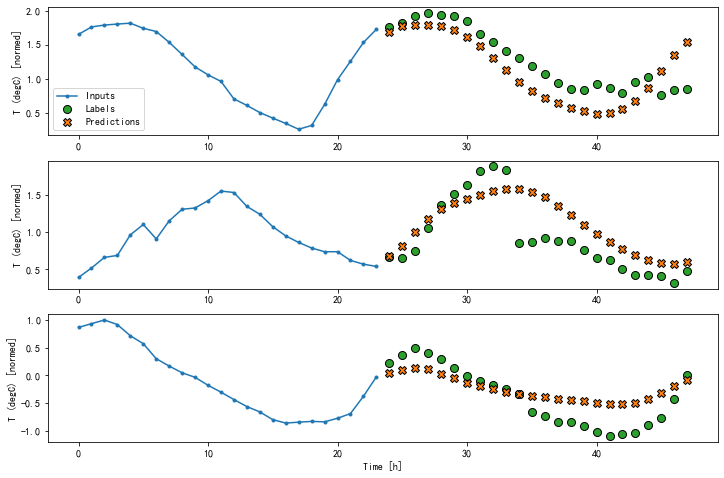

In [89]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

### Performance

There are clearly diminishing returns as a function of model complexity on this problem:

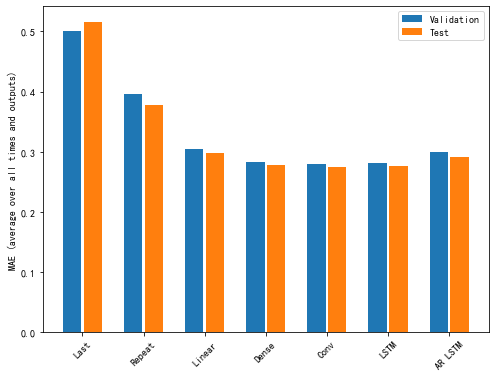

In [90]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

The metrics for the multi-output models in the first half of this tutorial show the performance averaged across all output features. These performances are similar but also averaged across output time steps. 

In [91]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.5157
Repeat  : 0.3774
Linear  : 0.2982
Dense   : 0.2781
Conv    : 0.2751
LSTM    : 0.2759
AR LSTM : 0.2907


The gains achieved going from a dense model to convolutional and recurrent models are only a few percent (if any), and the autoregressive model performed clearly worse. So these more complex approaches may not be worth while on **this** problem, but there was no way to know without trying, and these models could be helpful for **your** problem.

## Next steps

This tutorial was a quick introduction to time series forecasting using TensorFlow.

To learn more, refer to:

- Chapter 15 of <a href="https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/" class="external">Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow</a>, 2nd Edition.
- Chapter 6 of <a href="https://www.manning.com/books/deep-learning-with-python" class="external">Deep Learning with Python</a>.
- Lesson 8 of <a href="https://www.udacity.com/course/intro-to-tensorflow-for-deep-learning--ud187" class="external">Udacity's intro to TensorFlow for deep learning</a>, including the <a href="https://github.com/tensorflow/examples/tree/master/courses/udacity_intro_to_tensorflow_for_deep_learning" class="external">exercise notebooks</a>.

Also, remember that you can implement any <a href="https://otexts.com/fpp2/index.html" class="external">classical time series model</a> in TensorFlow—this tutorial just focuses on TensorFlow's built-in functionality.
